In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import glob
import os
from PIL import Image
import pickle
from tensorflow.python.keras.applications.xception import Xception, preprocess_input
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.preprocessing import image
%matplotlib inline

In [26]:

import seaborn as sns
sns.set()
#plt.rcParams['axes.titlesize'] = 22


# Waves - model probabilities

In [3]:
test_images = glob.glob('data/IR/test/*/*.jpg')
len_test = len(test_images)
print(f"Number of images : {len_test}\nsample file_name : {test_images[0]}")

Number of images : 3000
sample file_name : data/IR/test/plunge/147861587516.jpg


In [4]:
def wave_sort(path, I1, wave=[]):
    wave.append(I1)
    for i in range(1, 100):
        I2 = I1 + i
        if os.path.isfile(path+str(I2)+'.jpg'):
            wave = wave_sort(path, I2, wave)
            return wave
    return wave


In [5]:
def get_waves(file_path):
    waves = []
    files = sorted(glob.glob(file_path+'/*.jpg'))
    names = list(map(lambda x: int(x.split('/')[-1][:-4]), files))
    for i in names:
        try:
            if i not in waves[-1]:
                waves.append( wave_sort(file_path+'/', i, []) )
        except:
            waves.append( wave_sort(file_path+'/', i, []) )
            
    return waves

In [6]:
def plot_wave(path, wave):
    for i in wave:
        img = Image.open(path + '/' + str(i) + '.jpg')
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.pause(0.1)

In [7]:
plunge_waves = get_waves('data/IR/test/plunge')
spill_waves = get_waves('data/IR/test/spill')
non_waves = get_waves('data/IR/test/nonbreaking')

In [8]:
print(f"number of waves in test: \nplunge : {len(plunge_waves)}" + \
                      f"\nspill : {len(spill_waves)} " + \
                      f"\nnonbreaking : {len(non_waves)}")

number of waves in test: 
plunge : 3
spill : 23 
nonbreaking : 20


In [9]:
# Load the best models

base_model = Xception(weights='imagenet')
try:
    CNNmodel = Model(base_model.input, base_model.get_layer('avg_pool').output)	  
except:
    CNNmodel = Model(input=base_model.input, output=base_model.get_layer('avg_pool').output)
image_size = (299, 299)

with open('out/xception/IRclassifier.pickle', 'rb') as f:
    irmodel = pickle.load(f)
    
with open('out/xception/Floclassifier.pickle', 'rb') as f:
    flomodel = pickle.load(f)
    
with open('out/xception/IR2classifier.pickle', 'rb') as f:
    IR2model = pickle.load(f)

with open('out/xception/IR2flo_classifier.pickle', 'rb') as f:
    IRflomodel = pickle.load(f)
    
with open('out/xception/IR2flo_late_classifier.pickle', 'rb') as f:
    latemodel = pickle.load(f)
    
    
with open('out/xception/IRclassifier_imaug.pickle', 'rb') as f:
    irmodel_aug = pickle.load(f)
    
with open('out/xception/Floclassifier_imaug.pickle', 'rb') as f:
    flomodel_aug = pickle.load(f)
    
#with open('out/xception/IR2flo_classifier_imaug.pickle', 'rb') as f:
#    IRflomodel_aug = pickle.load(f)
    
#with open('out/xception/IR2classifier_imaug.pickle', 'rb') as f:
#    IR2model_aug = pickle.load(f)
    
with open('out/xception/IR2flo_late_classifier_imaug.pickle', 'rb') as f:
    latemodel_aug = pickle.load(f)

/home/ryan/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [10]:
# brier score
def brier_mult(true, preds):
    return np.mean(np.sum((true-preds)**2, -1))

In [11]:

def inform(true, preds):
    tp = np.zeros(3)
    tn = np.zeros(3)
    fp = np.zeros(3)
    fn = np.zeros(3)
    
    for lab, pred in zip(true, preds):
        if lab == pred:
            tp[lab] += 1
            for i in range(len(tn)):
                if i != lab:
                    tn[i] += 1
        if lab != pred:
            fp[pred] += 1
            fn[lab] += 1
            for i in range(len(tn)):
                if i != pred or lab:
                    tn[i] += 1

    return (tp/(tp+fn)+tn/(tn+fp) -1)

def load_h5_test(feat_path, label_path):
    features = h5py.File(feat_path, 'r')
    labels = h5py.File(label_path, 'r')
    return features, labels

def make_preds(features, model):
    pred = model.predict_proba(features)
    return pred

In [12]:
test_IR = h5py.File('out/xception/IRtestfeatures.h5', 'r')
test_IR = test_IR['dataset_1']
test_IRlab = h5py.File('out/xception/IRtestlabels.h5', 'r')
test_IRlab = test_IRlab['dataset_1']

test_flo = h5py.File('out/xception/Flotestfeatures.h5', 'r')
test_flo = test_flo['dataset_1']
test_flolab = h5py.File('out/xception/Flotestlabels.h5', 'r')
test_flolab = test_flolab['dataset_1']

test_IR2 = h5py.File('out/xception/IR2testfeatures.h5', 'r')
test_IR2 = test_IR2['dataset_1']
test_IR2lab = h5py.File('out/xception/IR2testlabels.h5', 'r')
test_IR2lab = test_IR2lab['dataset_1']

test_IRflo = h5py.File('out/xception/IR2flo_testfeatures.h5', 'r')
test_IRflo = test_IRflo['dataset_1']
test_IRflolab = h5py.File('out/xception/IR2flo_testlabels.h5', 'r')
test_IRflolab = test_IRflolab['dataset_1']

test_IRflo_late = h5py.File('out/xception/IR2flo_late_testfeatures.h5', 'r')
test_IRflo_late = test_IRflo_late['dataset_1']
test_IRflolab_late = h5py.File('out/xception/IR2flo_late_testlabels.h5', 'r')
test_IRflolab_late = test_IRflolab_late['dataset_1']

In [13]:
print("\t NB \t\t PL \t\t SP")
IRpreds = make_preds(test_IR, irmodel)
irinform = inform(test_IRlab[:], np.argmax(IRpreds, -1))
print("IR\t", irinform, np.mean(irinform))

flopreds = make_preds(test_flo, flomodel)
floinform = inform(test_flolab[:], np.argmax(flopreds, -1))
print("Flo\t", floinform, np.mean(floinform))

IR2preds = make_preds(test_IR2, IR2model)
ir2inform = inform(test_IR2lab[:], np.argmax(IR2preds, -1))
print("IR2\t", ir2inform, np.mean(ir2inform))

IRflopreds = make_preds(test_IRflo, IRflomodel)
IRfloinform = inform(test_IRflolab[:], np.argmax(IRflopreds, -1))
print("IRflo\t", IRfloinform, np.mean(IRfloinform))

latepreds = make_preds(test_IRflo_late, latemodel)
lateinform = inform(test_IRflolab_late[:], np.argmax(latepreds, -1))
print("Late\t", lateinform, np.mean(lateinform))


	 NB 		 PL 		 SP
IR	 [0.86790203 0.41339523 0.79078056] 0.6906926066484314
Flo	 [0.8988656  0.57878565 0.81335196] 0.7636677362919103
IR2	 [0.89559865 0.42398363 0.83930621] 0.7196294948595882
IRflo	 [0.90078405 0.45234082 0.85406813] 0.735731000118912
Late	 [0.92550167 0.39863492 0.88048795] 0.7348748469711719


In [14]:
print("\t NB \t\t PL \t\t SP")
IRpreds = make_preds(test_IR, irmodel_aug)
irinform = inform(test_IRlab[:], np.argmax(IRpreds, -1))
print("IRaug\t", irinform, np.mean(irinform))

flopreds = make_preds(test_flo, flomodel_aug)
floinform = inform(test_flolab[:], np.argmax(flopreds, -1))
print("Floaug\t", floinform, np.mean(floinform))

#IR2preds = make_preds(test_IR2, ir2model_aug)
#ir2inform = inform(test_IRlab[:], np.argmax(IR2preds, -1))
#print("IR2aug\t", ir2inform, np.mean(ir2inform))

#IRflopreds = make_preds(test_IRflo, IRflomodel_aug)
#IRfloinform = inform(test_IRflolab[:], np.argmax(IRflopreds, -1))
#print("IRfloaug\t", IRfloinform, np.mean(IRfloinform))

latepreds = make_preds(test_IRflo_late, latemodel_aug)
lateinform = inform(test_IRflolab_late[:], np.argmax(latepreds, -1))
print("Lateaug\t", lateinform, np.mean(lateinform))


	 NB 		 PL 		 SP
IRaug	 [0.87108636 0.51204749 0.7986015 ] 0.7272451165185799
Floaug	 [0.9007953  0.49441164 0.80273148] 0.7326461394780464
Lateaug	 [0.92315664 0.4526798  0.88196712] 0.752601187653395


In [15]:
def one_hot(labels):
    onehot = np.zeros((len(labels), 3))
    for i, label in enumerate(labels):
        onehot[i, label] = 1
    return onehot

In [16]:
print(brier_mult(one_hot(test_IRlab), IRpreds))
print(brier_mult(one_hot(test_flolab), flopreds))
print(brier_mult(one_hot(test_IRflolab), IRflopreds))
print(brier_mult(one_hot(test_IRflolab_late), latepreds))

0.12252844920429097
0.10550311800985143
0.08680924713463056
0.07073771109658655


In [17]:
def get_wave_probs(cla, waves, indx):
    ir_prob = []
    flo_prob = []
    ir_brier = []
    flo_brier = []
    lateprob = []
    late_brier = []
    one_hot = np.zeros(3)
    one_hot[indx] = 1
    for wave in waves:
        ir_temp = []
        flo_temp = []
        ir_brier_temp = []
        flo_brier_temp = []
        lateprob_temp = []
        late_brier_temp = []
        for i in wave:
            try:
                #fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))
                IRimg = image.load_img(f'data/IR/test/{cla}/{i}.jpg', target_size = image_size)
                IRimg = np.array(IRimg)

                #ax1.imshow(IRimg, cmap='gray')
                #ax1.set_title(f'{cla}')
                #ax1.axis('off')

                IRimg = preprocess_input(IRimg)[None]
                IRfeatures = CNNmodel.predict(IRimg)
                IRpred = irmodel.predict_proba(IRfeatures)[0]
                ir_temp.append(IRpred)
                ir_brier_temp.append(brier_mult(one_hot, IRpred))

                #ax2.bar(range(3), IRpred)
                #ax2.set_title('IR model')
                #ax2.set_ylim(0, 1)
                #ax2.set_xticklabels([ '', 'nonbreaking', 'plunge', 'spill',])

                floimg = image.load_img(f'data/flow/test/{cla}/{i}.png', target_size = image_size)
                floimg = np.array(floimg)
                floimg = preprocess_input(floimg)[None]
                Flofeatures = CNNmodel.predict(floimg)
                flopred = flomodel.predict_proba(Flofeatures)[0]
                flo_temp.append(flopred)
                flo_brier_temp.append(brier_mult(one_hot, flopred))

                #ax3.bar(range(3), flopred)
                #ax3.set_title('Optical flow model')
                #ax3.set_ylim(0, 1)
                #ax3.set_xticklabels([ '', 'nonbreaking', 'plunge', 'spill',])

                Latefeatures = np.concatenate((IRfeatures, Flofeatures), 1)
                latepred = latemodel.predict_proba(Latefeatures)[0]
                lateprob_temp.append(latepred)
                late_brier_temp.append(brier_mult(one_hot, latepred))

                #ax4.bar(range(3), latepred)
                #ax4.set_title('IR and OF model')
                #ax4.set_ylim(0, 1)
                #ax4.set_xticklabels(['', 'nonbreaking', 'plunge', 'spill'])

                #fig.savefig(f'notebook_out/{cla}_{indx}_{i}')

            except:
                pass
        ir_prob.append(ir_temp)
        flo_prob.append(flo_temp)
        ir_brier.append(ir_brier_temp)
        flo_brier.append(flo_brier_temp)
        lateprob.append(lateprob_temp)
        late_brier.append(late_brier_temp)

    return ir_prob, flo_prob, lateprob, ir_brier, flo_brier, late_brier

In [20]:
for i, j in enumerate(non_waves):
    print(i, len(j))

0 113
1 86
2 46
3 45
4 34
5 18
6 5
7 226
8 37
9 31
10 63
11 43
12 98
13 298
14 115
15 254
16 208
17 207
18 90
19 243


In [140]:
IRnon, Flonon, Latenon, IRnon_brier, Flonon_brier, Latenon_brier = get_wave_probs('nonbreaking',
                                                                      non_waves, 0)

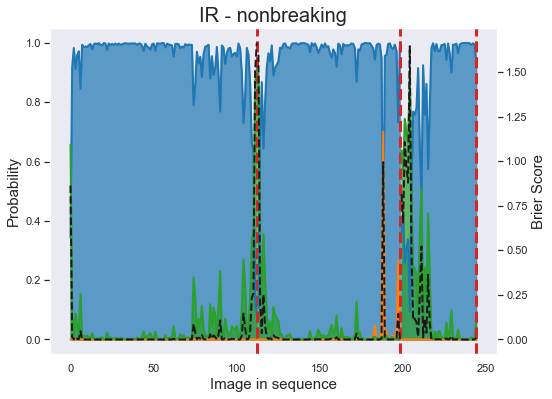

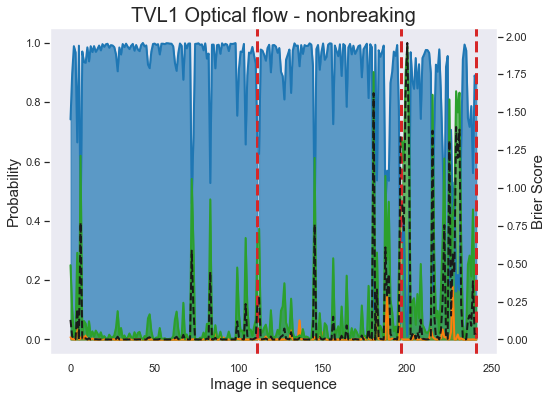

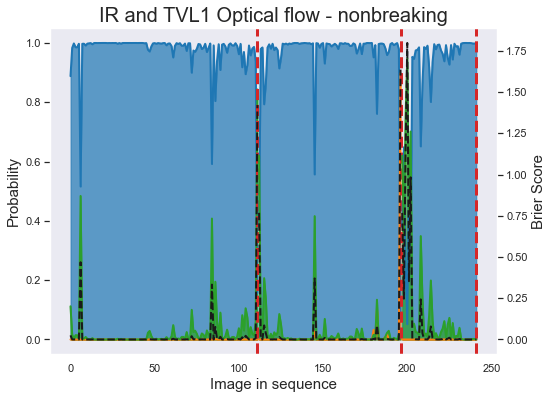

In [198]:
plot_wave_probs(IRnon, IRnon_brier, 'IR - nonbreaking')
plot_wave_probs(Flonon, Flonon_brier, 'TVL1 Optical flow - nonbreaking')
plot_wave_probs(Latenon, Latenon_brier, 'IR and TVL1 Optical flow - nonbreaking')

In [197]:
def plot_wave_probs(wave_prob, brier, title):
    labels = ['nonbreaking', 'plunge', 'spill']
    colours = ['tab:blue', 'tab:orange', 'tab:green']
    k = 0
    brier = reduce(operator.add, brier)
    fig, ax = plt.subplots(1,1)
    ax2 = plt.twinx()
    for wave in wave_prob:
        prob = np.array(wave)
        j = range(k, k+len(prob))
        for i, l in enumerate(labels):
            ax.plot(j, prob[:, i], colours[labels.index(l)], linewidth=2)
            ax.fill_between(j, prob[:,i], color=colours[labels.index(l)], alpha=0.7, label=l if k==0 else None)
        ax2.plot(j, brier[j[0]:j[-1]+1], 'k--', linewidth=2, label=f'Brier score:{np.mean(brier[:200]):.2f}' if k==0 else None)
        k += len(prob)
        ax.axvline(k-1, color='tab:red', linestyle='--', linewidth=3)
        if k >= 200: 
            break # Dont plot more than 200 probability predictions (stops overcrowding plots)
    ax.set_xlabel('Image in sequence', size=15)
    ax.set_ylabel('Probability', size=15)
    plt.title(title, size=20)
    #ax.legend(bbox_to_anchor=(1.07,1))

    ax2.set_ylabel('Brier Score', size=15)
    #ax2.legend(bbox_to_anchor=(1.07,0.1))
    plt.savefig(f'notebook_out/{title}', bbox_inches='tight')
    plt.show()

In [22]:
plungecat = []
for i in plunge_waves:
    plungecat = plungecat + i

In [23]:
IRplunge, Floplunge, Lateplunge, IRplunge_brier, Floplunge_brier, Lateplunge_brier = get_wave_probs('plunge',
                                                        plunge_waves, 1)

In [44]:
import operator
from functools import reduce

sns.set_style('dark')
plt.rcParams['figure.figsize'] = (8,6)

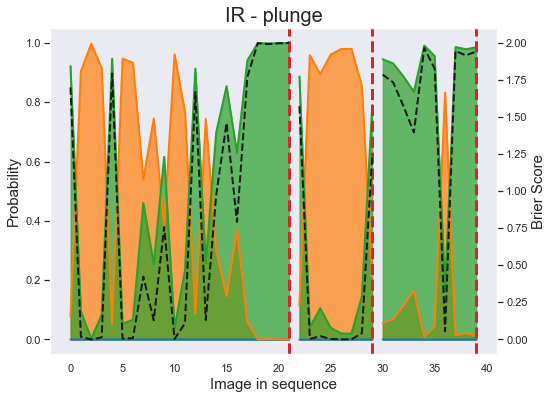

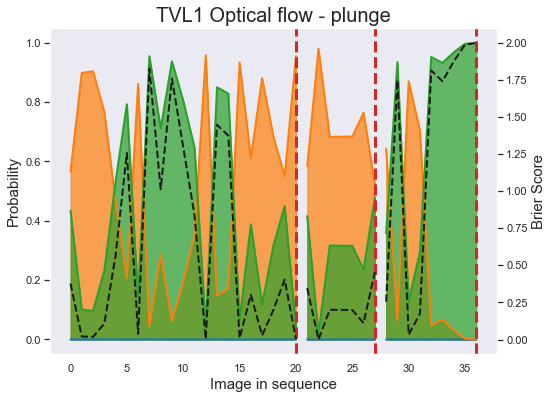

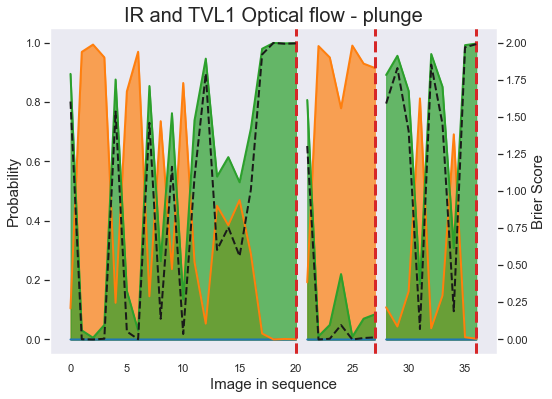

In [183]:
plot_wave_probs(IRplunge, IRplunge_brier, 'IR - plunge')
plot_wave_probs(Floplunge, Floplunge_brier, 'TVL1 Optical flow - plunge')
plot_wave_probs(Lateplunge, Lateplunge_brier, 'IR and TVL1 Optical flow - plunge')

In [121]:
IRspill, Flospill, Latespill, IRspill_brier, Flospill_brier, Latespill_brier = get_wave_probs('spill', 
                                                                  spill_waves, 
                                                                    2)

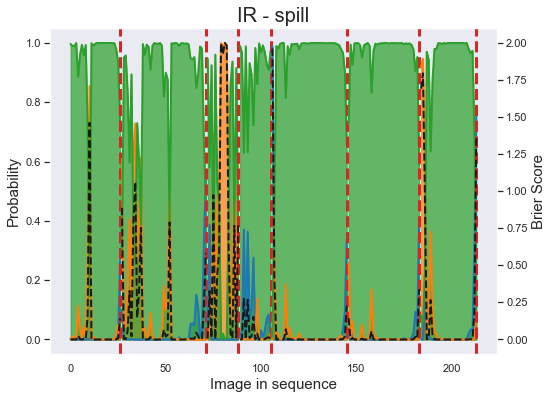

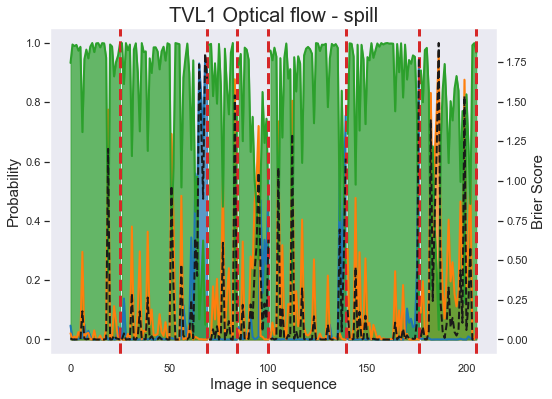

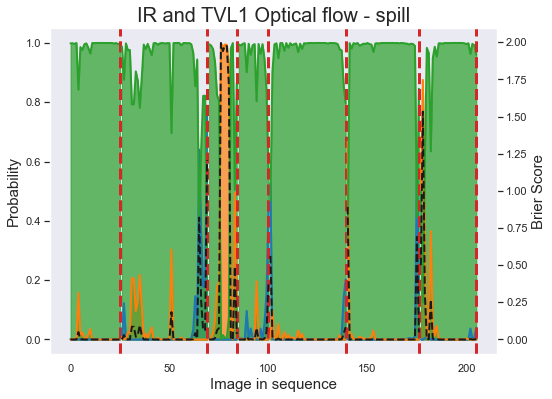

In [184]:
plot_wave_probs(IRspill, IRspill_brier, 'IR - spill')
plot_wave_probs(Flospill, Flospill_brier, 'TVL1 Optical flow - spill')
plot_wave_probs(Latespill, Latespill_brier, 'IR and TVL1 Optical flow - spill')

In [179]:
def print_brier(brier):
    brier = reduce(operator.add, brier)
    return np.round(np.mean(brier),2)
    
    
l = [IRplunge_brier,
     Floplunge_brier,
     Lateplunge_brier,
     IRspill_brier,
     Flospill_brier,
     Latespill_brier,
     IRnon_brier,
     Flonon_brier,
     Latenon_brier]

r = ["IR - plunge brier \t:\t",
     "Flo - plunge brier \t:\t",
    "IR+Flo - plunge brier \t:\t",
    "IR - spill brier \t:\t",
    "Flo - spill brier \t:\t",
    "IR+Flo - spill brier \t:\t",
    "IR - non brier \t\t:\t",
    "Flo - non brier \t:\t",
    "IR+Flo - non brier \t:\t",]

for i,j in zip(l,r):
    print(j ,print_brier(i))

IR - plunge brier 	:	 0.97
Flo - plunge brier 	:	 0.7
IR+Flo - plunge brier 	:	 0.91
IR - spill brier 	:	 0.22
Flo - spill brier 	:	 0.22
IR+Flo - spill brier 	:	 0.12
IR - non brier 		:	 0.09
Flo - non brier 	:	 0.06
IR+Flo - non brier 	:	 0.05


# Clustering

In [12]:
def get_feat_lab(feat_path, lab_path):
    feat = h5py.File(feat_path, 'r')
    lab = h5py.File(lab_path, 'r')
    
    feat = feat['dataset_1']
    lab = lab['dataset_1']
    return feat, lab

In [13]:
train_IR, train_IRlab = get_feat_lab('out/xception/IRfeatures.h5', 'out/xception/IRlabels.h5')
train_flo, train_flolab = get_feat_lab('out/xception/Flofeatures.h5','out/xception/Flolabels.h5')
train_IRflo, train_IRflolab = get_feat_lab('out/xception/IR2flo_features.h5', 'out/xception/IR2flo_labels.h5')
train_IRflo_late, train_IRflolab_late = get_feat_lab('out/xception/IR2flo_late_features.h5', 'out/xception/IR2flo_late_labels.h5')


In [14]:
from sklearn.decomposition import PCA


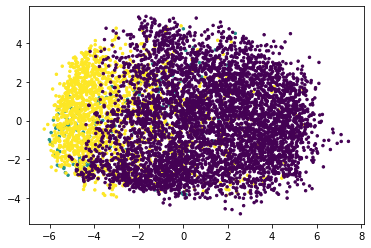

In [15]:
pca = PCA(n_components=2)
pc = pca.fit_transform(train_IR)
plt.scatter(pc[:,0], pc[:,1], c=train_IRlab, s=6, label=train_IRlab)

In [16]:
pca = PCA(n_components=2)
pc = pca.fit_transform(aug_train_flo)
plt.scatter(pc[:,0], pc[:,1], c=aug_train_flolab, s=6, label=aug_train_flolab)

NameError: name 'aug_train_flo' is not defined

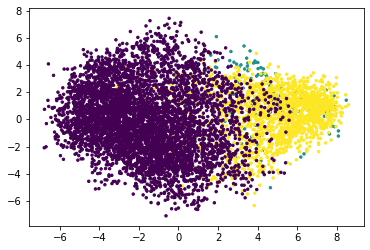

In [17]:
pca = PCA(n_components=2)
pc = pca.fit_transform(train_IRflo_late)
plt.scatter(pc[:,0], pc[:,1], c=train_IRflolab_late, s=6, label=train_IRflolab_late)

In [50]:
def umap_clust(features):
    cluster = umap.UMAP(n_neighbors=30, min_dist=0.0, 
                          n_components=2, random_state=1).fit_transform(features)
    return cluster

def umap_plot(cluster, label, title, save=None, **kwargs):
    fig, ax = plt.subplots(**kwargs)
    scatter = ax.scatter(cluster[:, 0], cluster[:, 1], marker = 'D',
                c=label, s=10, label=label)
    plt.legend(handles=scatter.legend_elements()[0], labels=["nonbreaking", "plunge","spill"], title='classes', prop={'size': 16})
    plt.title(title)
    plt.axis('off')
    
    if save:
        plt.savefig(save)
    plt.show()

def pl_sp(features, labels):
    new_data = np.array([])
    new_label = np.array([])
    for i, lab in enumerate(labels):
        if lab != 0:
            new_data = np.append(new_data, features[i])
            new_label = np.append(new_label, lab)
    new_data = np.reshape(new_data, (len(new_data)//np.shape(features)[1], np.shape(features)[1]))
    return new_data, new_label

In [19]:
IR_train_ps, IR_train_labps = pl_sp(train_IR, train_IRlab)
Flo_train_ps, Flo_train_labps = pl_sp(train_flo, train_flolab)
#IRFlo_train_ps, IRFlo_train_labps = pl_sp(train_IRflo_late, train_IRflolab_late)

In [21]:
IR_cluster_ps = umap_clust(IR_train_ps)
Flo_cluster_ps = umap_clust(Flo_train_ps)
#IRFlo_cluster_ps = umap_clust(IRFlo_train_ps)

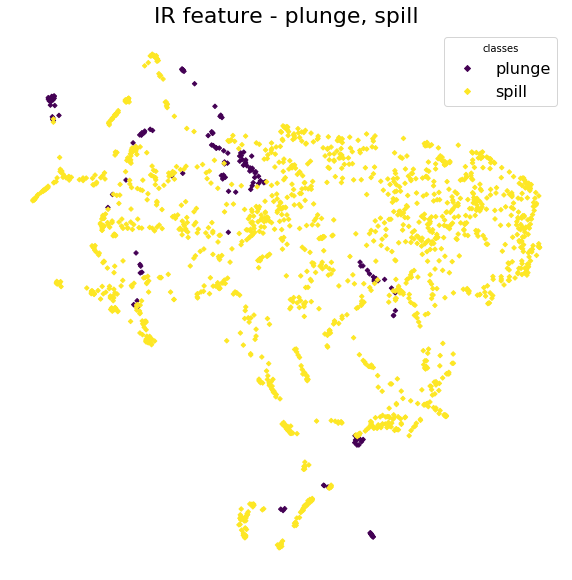

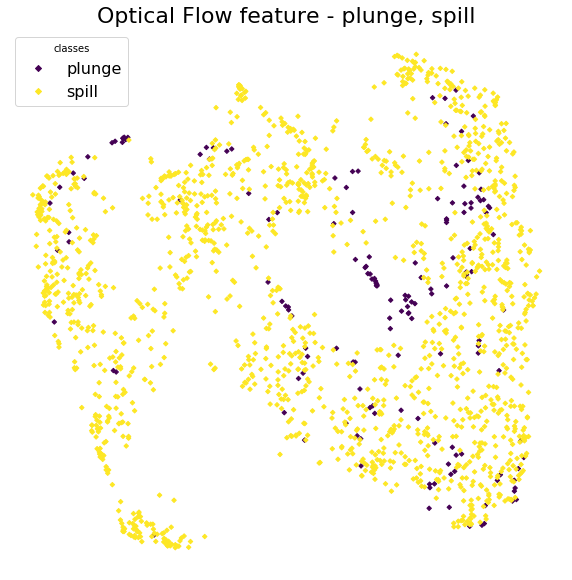

In [44]:
umap_plot(IR_cluster_ps, IR_train_labps, 'IR feature - plunge, spill',
         save='IR_cluster_PS', figsize=(10,10))
umap_plot(Flo_cluster_ps, Flo_train_labps, 'Optical Flow feature - plunge, spill',
         save='OF_cluster_PS', figsize=(10,10))
#umap_plot(IRFlo_cluster_ps, IRFlo_train_labps, 'IR and Optical Flow feature - plunge, spill',
        #save='IR_OF_cluster_PS', figsize=(10,10))

In [27]:
IR_cluster = umap_clust(train_IR)
flo_cluster = umap_clust(train_flo)
IRflo_cluster = umap_clust(train_IRflo)
IRflo_late_cluster = umap_clust(train_IRflo_late)

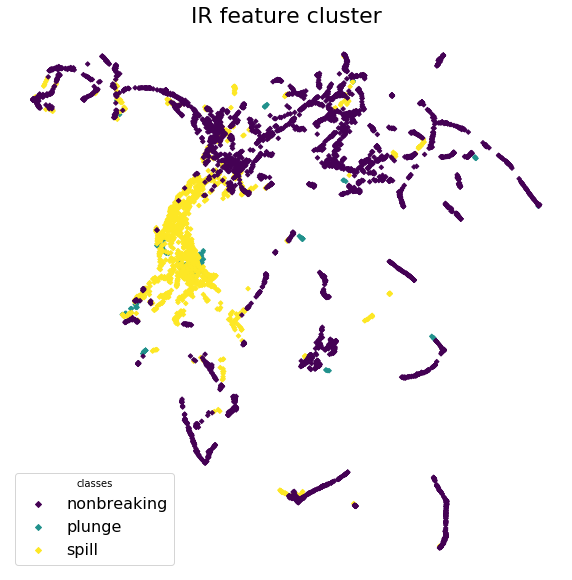

In [51]:
umap_plot(IR_cluster, train_IRlab, 'IR feature cluster', 
        save='IR_features_cluster.png', figsize=(10,10))

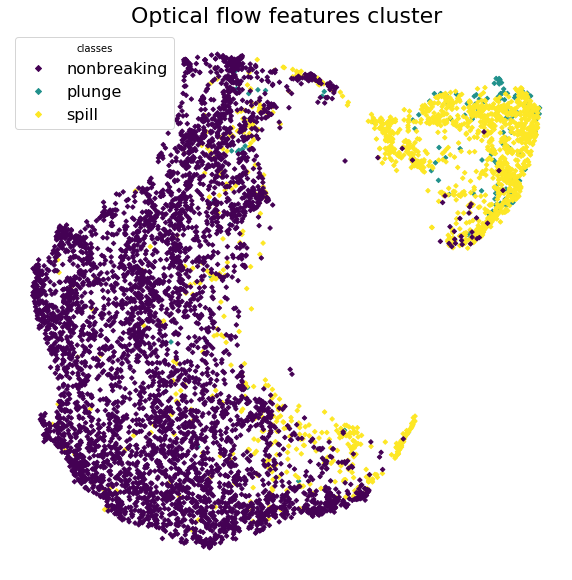

In [52]:
umap_plot(flo_cluster, train_flolab, 'Optical flow features cluster',
          'OpticalFlow_features_cluster.png', figsize=(10,10))

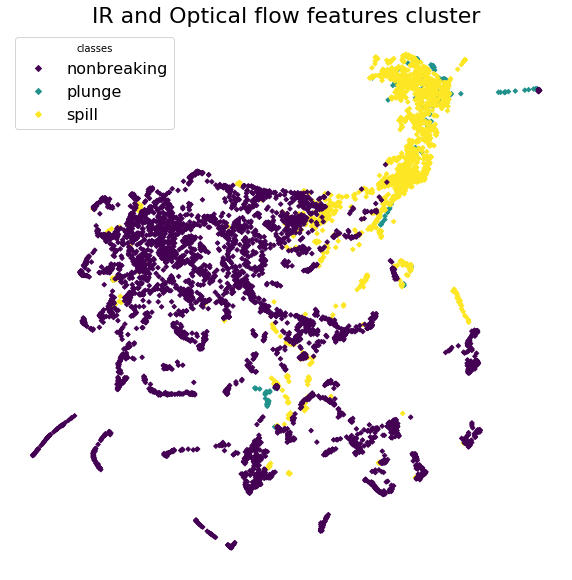

In [53]:
umap_plot(IRflo_cluster, train_IRflolab, 'IR and Optical flow features cluster',
          'IR_OpticalFlow_features_cluster.png', figsize=(10,10))

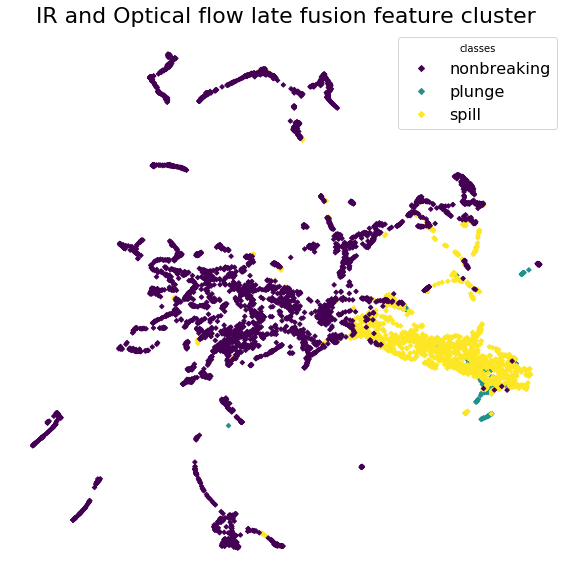

In [54]:
umap_plot(IRflo_late_cluster, train_IRflolab_late, 
          'IR and Optical flow late fusion feature cluster',
         save='IR_flo_late_features_cluster.png',
         figsize=(10,10))

# AUG

In [31]:
aug_train_IR = h5py.File('out/xception/IRfeatures_imaug.h5', 'r')
aug_train_IR = aug_train_IR['dataset_1']
aug_train_IRlab = h5py.File('out/xception/IRlabels_imaug.h5', 'r')
aug_train_IRlab = aug_train_IRlab['dataset_1']

aug_train_flo = h5py.File('out/xception/Flofeatures_imaug.h5', 'r')
aug_train_flo = aug_train_flo['dataset_1']
aug_train_flolab = h5py.File('out/xception/Flolabels_imaug.h5', 'r')
aug_train_flolab = aug_train_flolab['dataset_1']

augtrain_IRflo_late = h5py.File('out/xception/IR2flo_late_features_imaug.h5', 'r')
augtrain_IRflo_late = augtrain_IRflo_late['dataset_1']
augtrain_IRflolab_late = h5py.File('out/xception/IR2flo_late_labels_imaug.h5', 'r')
augtrain_IRflolab_late = augtrain_IRflolab_late['dataset_1']


In [32]:
augIR_cluster = umap.UMAP(n_neighbors=30, min_dist=0.0, n_components=2, random_state=1).fit_transform(aug_train_IR)
augflo_cluster = umap.UMAP(n_neighbors=30, min_dist=0.0, n_components=2, random_state=1).fit_transform(aug_train_flo)
augIRflo_late_cluster = umap.UMAP(n_neighbors=30, min_dist=0.0, 
                               n_components=2, random_state=1).fit_transform(augtrain_IRflo_late)

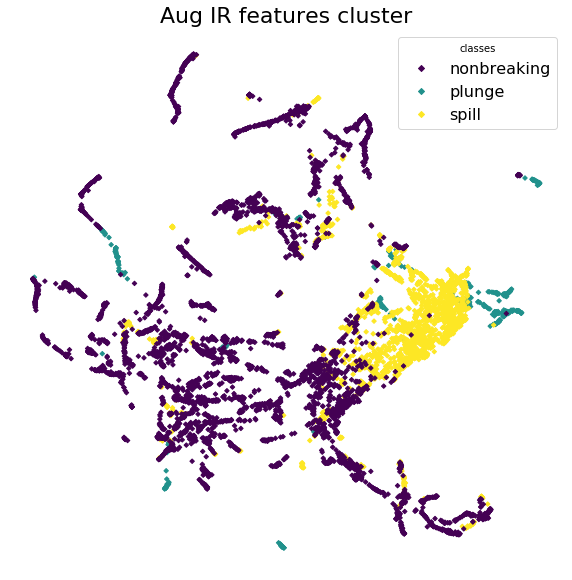

In [55]:
umap_plot(augIR_cluster, aug_train_IRlab, 'Aug IR features cluster',
          save = 'AUG_IR_features_cluster',figsize=(10,10))

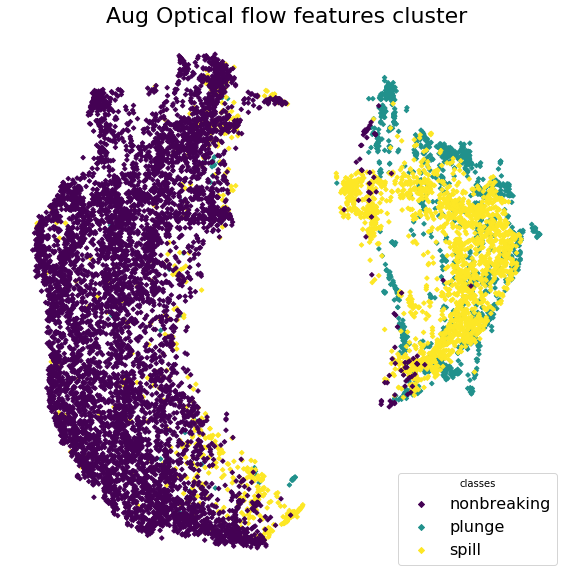

In [56]:
umap_plot(augflo_cluster, aug_train_flolab, 'Aug Optical flow features cluster',
          save='AUG_OF_features_cluster', figsize=(10,10))

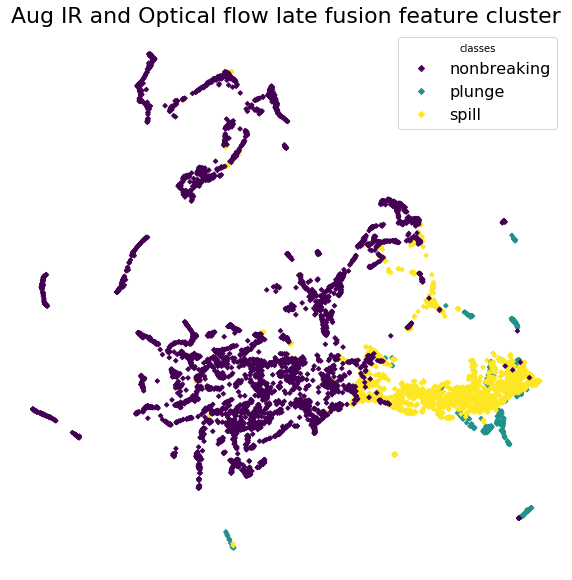

In [57]:
umap_plot(augIRflo_late_cluster, augtrain_IRflolab_late, 
        'Aug IR and Optical flow late fusion feature cluster',
          save = 'AUG_IR_OF_feautres_cluster',
         figsize=(10,10))